In [1]:
!pip install mplfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 2.7 MB/s eta 0:00:00


In [2]:
!pip install pyramid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 5.9 MB/s eta 0:00:00


In [3]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.9 MB/s eta 0:00:00


In [4]:
!pip install pdblp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pdblp: filename=pdblp-0.1.8-py3-none-any.whl size=18650 sha256=d4a0f28c2647d3d95b798f28a1acd4718d3260aa68c500acd72e49162277cb14
  Stored in directory: /root/.cache/pip/wheels/d4/5d/a3/c5bf685e879e8e4899c73d59048926f1846a08e5d141adcbda
Successfully built pdblp


In [5]:
from google.colab import drive
from datetime import datetime
import numpy as np
import warnings

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_log_error

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import math
import mplfinance as mpf

from pmdarima.arima import auto_arima
import scipy.stats as stats

**Load and select data**

In [6]:
from google.colab import drive
drive.mount('/content/drive')
#从本地云盘导入数据

Mounted at /content/drive


In [7]:
# Load data
path = '/content/drive/MyDrive/stock-price-prediction/data/test1.csv'
df = pd.read_csv(path, index_col=0)
close=df[['Adj Close']]
df['diff_close'] = df['Adj Close'] - df['Adj Close'].shift(1)
df['simple_return']=df['diff_close'] / df['Adj Close'].shift(1)
display(df)

,Adj Close,diff_close,simple_return
Date,,,
2009/1/2,931.80,NaN,NaN
2009/1/5,927.45,-4.35,-0.004668
2009/1/6,934.70,7.25,0.007817
2009/1/7,906.65,-28.05,-0.030010
2009/1/8,909.73,3.08,0.003397
...,...,...,...
2019/12/23,3224.01,2.79,0.000866
2019/12/24,3223.38,-0.63,-0.000195
2019/12/26,3239.91,16.53,0.005128


In [8]:
# 只需要运行一次,为了剔除第一行NAN数据
df.drop(index=df.index[0], axis=0, inplace=True)
display(df)

,Adj Close,diff_close,simple_return
Date,,,
2009/1/5,927.45,-4.35,-0.004668
2009/1/6,934.70,7.25,0.007817
2009/1/7,906.65,-28.05,-0.030010
2009/1/8,909.73,3.08,0.003397
2009/1/9,890.35,-19.38,-0.021303
...,...,...,...
2019/12/23,3224.01,2.79,0.000866
2019/12/24,3223.38,-0.63,-0.000195
2019/12/26,3239.91,16.53,0.005128


In [9]:
row=df.iloc[1852]
row

Adj Close        2046.610000
diff_close        -17.500000
simple_return      -0.008478
Name: 2016/5/13, dtype: float64

In [10]:
# s_return=df['simple_return']
s_return=df[['simple_return']]
s_return.head()

,simple_return
Date,
2009/1/5,-0.004668
2009/1/6,0.007817
2009/1/7,-0.030010
2009/1/8,0.003397
2009/1/9,-0.021303


In [11]:
test_price=df[['Adj Close']]
test_price.head()

,Adj Close
Date,
2009/1/5,927.45
2009/1/6,934.70
2009/1/7,906.65
2009/1/8,909.73
2009/1/9,890.35


In [12]:
df_price = test_price.copy()[1852:]
df_price

,Adj Close
Date,
2016/5/13,2046.61
2016/5/16,2066.66
2016/5/17,2047.21
2016/5/18,2047.63
2016/5/19,2040.04
...,...
2019/12/23,3224.01
2019/12/24,3223.38
2019/12/26,3239.91


**Summary Statistics**

In [13]:
# describe data
# 看第一列和第三列就好了
df.describe()

,Adj Close,diff_close,simple_return
count,2766.000000,2766.000000,2766.000000
mean,1870.090018,0.827726,0.000501
std,633.209531,17.137104,0.010259
min,676.530000,-113.190000,-0.066634
25%,1310.225000,-6.265000,-0.003456
50%,1905.070000,1.125000,0.000661
75%,2364.605000,9.287500,0.005318
max,3240.020000,116.600000,0.070758


In [14]:
skewness = df.skew()
kurtosis = df.kurtosis()

In [15]:
print(skewness)

Adj Close        0.199247
diff_close      -0.612320
simple_return   -0.242214
dtype: float64


In [16]:
print(kurtosis)

Adj Close       -1.081029
diff_close       4.939202
simple_return    5.094633
dtype: float64


In [17]:
# Null value check
s_return.isna().sum()

simple_return    0
dtype: int64

In [18]:
df.dtypes

Adj Close        float64
diff_close       float64
simple_return    float64
dtype: object

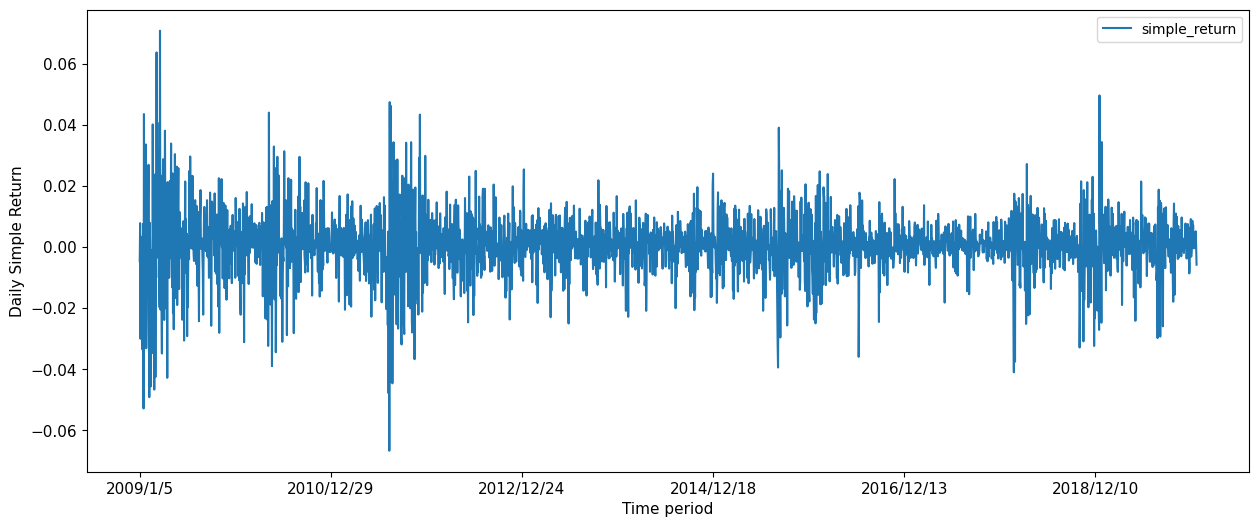

In [19]:
# show simple return graph (inc.trainning and predicting)
s_return.plot(y='simple_return', subplots=True, figsize=(15, 6), fontsize=11)
plt.xlabel('Time period', fontsize=11)
plt.ylabel('Daily Simple Return', fontsize=11)
plt.show()


In [20]:
s_array = np.array(s_return)
s_array

array([[-4.66838377e-03],
       [ 7.81713300e-03],
       [-3.00096288e-02],
       ...,
       [ 5.12815740e-03],
       [ 3.39515604e-05],
       [-5.78082851e-03]])

In [21]:
t_stat, p_value = stats.ttest_1samp(s_array, 0)

# 输出结果
print('t统计量:', t_stat)
print('p值:', p_value)

# 根据p值判断是否显著
alpha = 0.05 # 显著性水平
if p_value < alpha:
    print('收益率显著不等于0')
else:
    print('收益率不显著不等于0')

t统计量: [2.56969551]
p值: [0.01023075]
收益率显著不等于0


**ADF TEST & WHITE TEST**

In [22]:
# ADF test （这个不用看，下面还有一个）
result_adf=adfuller(s_return)
result_adf

(-11.870238346073577,
 6.529565555145025e-22,
 24,
 2741,
 {'1%': -3.4327379732269048,
  '5%': -2.862595034666578,
  '10%': -2.567331628897652},
 -17439.356207698096)

In [23]:
# check_stationarity函数定义
from statsmodels.tsa.stattools import adfuller

def check_stationarity(ts_data):
  
    # Rolling statistics
    roll_mean = ts_data.rolling(30, center=True, closed='both').mean() # ts_data的类型和roll_mean以及roll_std保持一致
    roll_std = ts_data.rolling(5, center=True, closed='both').std()
    # 修改roll_mean列名，方便之后画图
    roll_mean.columns = ['Rolling Mean(30 days)']
    
    # Plot rolling statistics
    roll_std.plot(y='Original Data', subplots=True, figsize=(15, 6), fontsize=11, label='Rolling Std Dev(5 days)')
    plt.ylabel('Rolling Std', fontsize=11)
    plt.legend()

    ax = ts_data.plot(figsize=(15, 6))
    roll_mean.plot(ax=ax)
    ax.legend()

    # Dickey-Fuller test
    print('Dickey-Fuller test results\n')
    df_test = adfuller(ts_data, regresults=False)
    test_result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','# of lags','# of obs'])
    print(test_result)
    for k,v in df_test[4].items():
        print('Critical value at %s: %1.5f' %(k,v))

In [24]:
test1 = df['simple_return']  # Series版本
test2 = df[['simple_return']] # Dataframe版本
# 修改test2列名，方便之后画图
test2.columns = ['Original Data']
test2

,Original Data
Date,
2009/1/5,-0.004668
2009/1/6,0.007817
2009/1/7,-0.030010
2009/1/8,0.003397
2009/1/9,-0.021303
...,...
2019/12/23,0.000866
2019/12/24,-0.000195
2019/12/26,0.005128


Dickey-Fuller test results

Test Statistic   -1.187024e+01
p-value           6.529566e-22
# of lags         2.400000e+01
# of obs          2.741000e+03
dtype: float64
Critical value at 1%: -3.43274
Critical value at 5%: -2.86260
Critical value at 10%: -2.56733


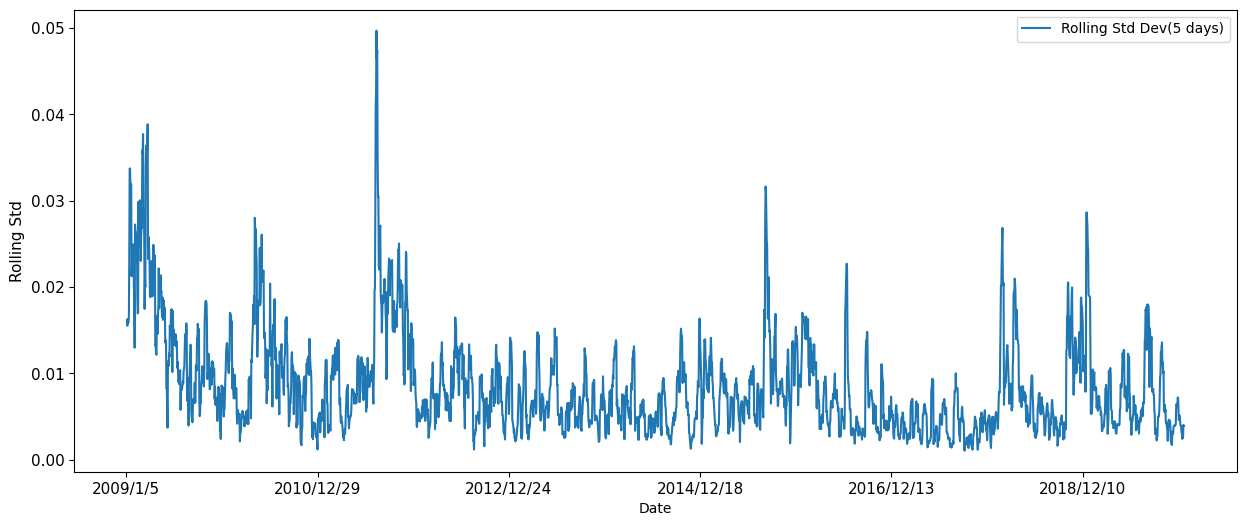

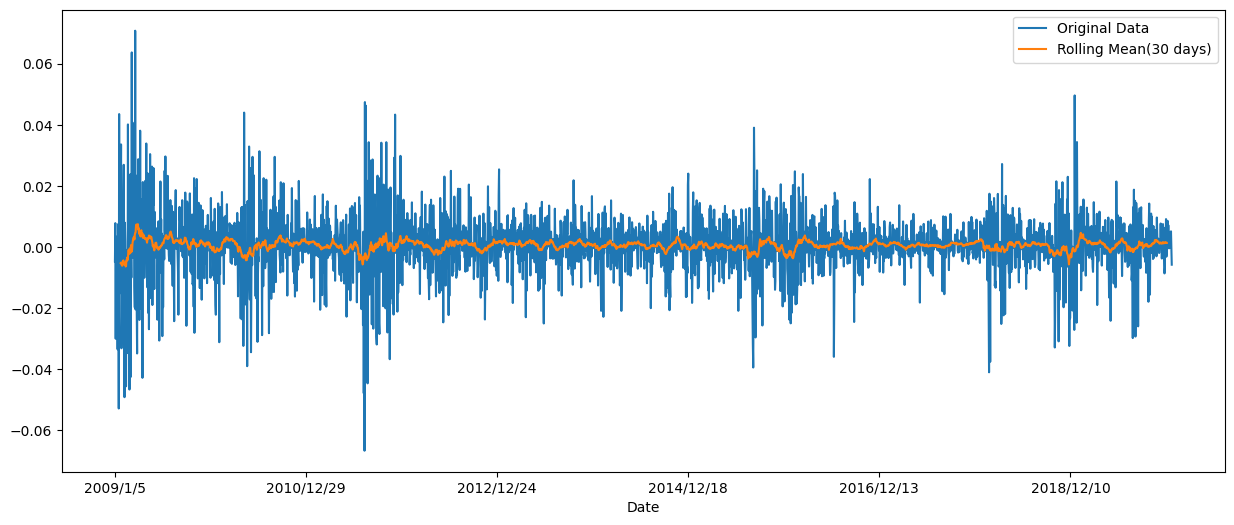

In [25]:
# 看ADF test，这个好像比上面那个出来的结果清晰一点，看这个吧
# 我好像没找到ADF图用matlab画的代码像stata出来的那个表，我们可以自己在word文档里面建个ADF的表，value都有，或者我再找找，问题不大
# p value和critical value都有
# test2是指s_return的Series格式
# 别动这张图，他的横坐标显示是个玄学= =，我整了好久终于正常了
check_stationarity(test2)

In [26]:
# White test
# lb_stat表示的是lags，应该就看lag=1时的值就好了吧（再check一下），因为此时p<0.01，拒绝原假设，证明原序列非白噪声序列
acorr_ljungbox(s_return, lags=None, boxpierce=False, 
               model_df=0, period=None, 
               return_df=True, auto_lag=False)

,lb_stat,lb_pvalue
1,11.725682,0.000616
2,12.078937,0.002383
3,14.331339,0.002487
4,15.349243,0.004029
5,23.071267,0.000327
6,23.138164,0.000751
7,23.662254,0.001306
8,24.835942,0.001657
9,26.756015,0.001535
10,29.596789,0.000997


**Create training and testing data sets**

Training data shape:  (1853, 1)
Test data shape:  (913, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

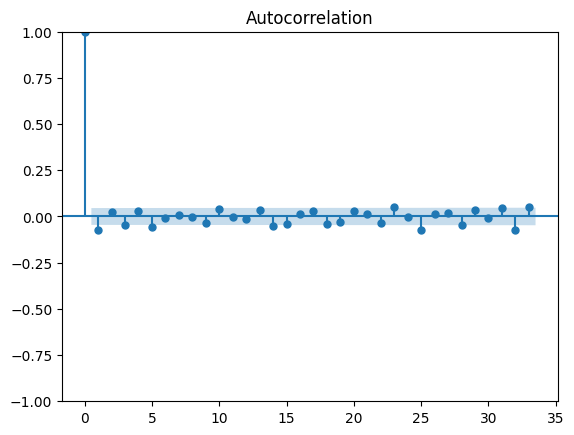

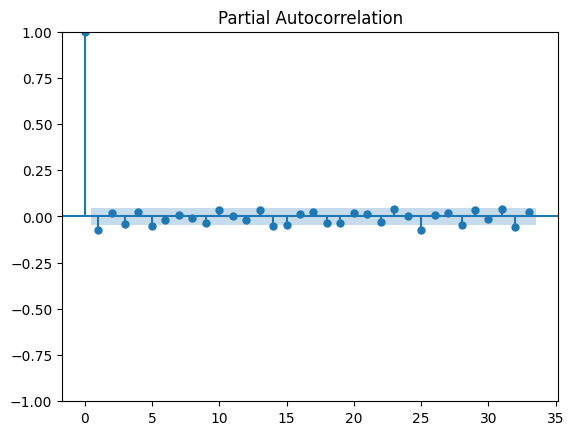

In [27]:
# divide the data into a training (67%) and test (33%) set.
n = int(len(s_return) * 0.67)

df_train = s_return.copy()[:n]
df_test = s_return.copy()[n:]

print('Training data shape: ', df_train.shape)
print('Test data shape: ', df_test.shape)
# print出来为（行，列）

#选择p和q的数值
# plot_acf(df_train['simple_return'])
plot_acf(df_train)
# plot_pacf(df_train['simple_return']) 
plot_pacf(df_train)
plt.show

In [28]:
df_train

,simple_return
Date,
2009/1/5,-0.004668
2009/1/6,0.007817
2009/1/7,-0.030010
2009/1/8,0.003397
2009/1/9,-0.021303
...,...
2016/5/9,0.000753
2016/5/10,0.012484
2016/5/11,-0.009562


In [29]:
df_test

,simple_return
Date,
2016/5/16,0.009797
2016/5/17,-0.009411
2016/5/18,0.000205
2016/5/19,-0.003707
2016/5/20,0.006019
...,...
2019/12/23,0.000866
2019/12/24,-0.000195
2019/12/26,0.005128


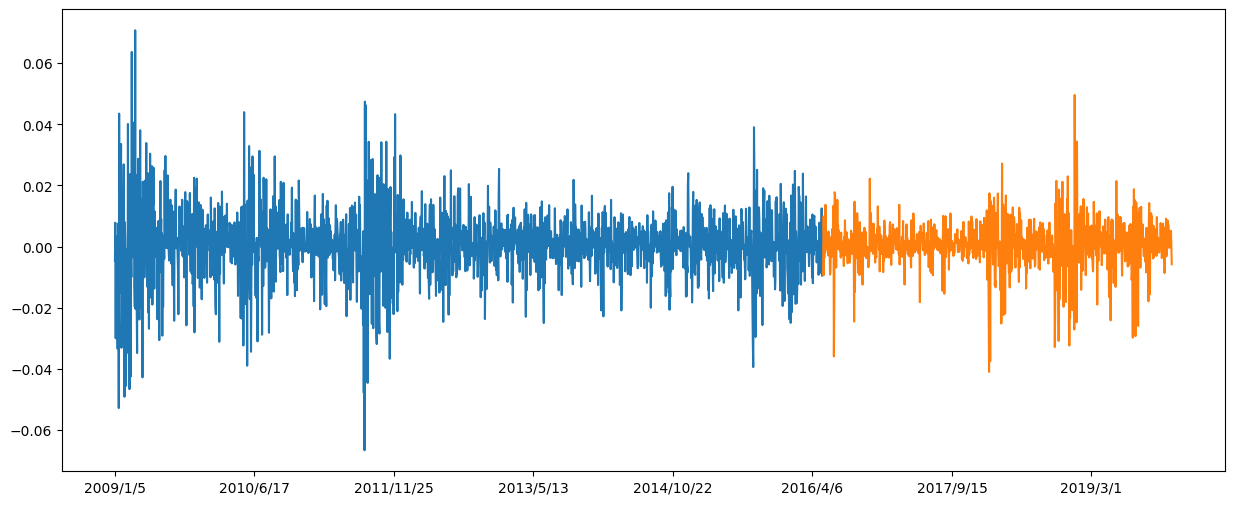

In [30]:
plt.figure(figsize=(15,6))
plt.plot(df_train,label="Train")
plt.plot(df_test,label="Test")
x_major_locator=MultipleLocator(365)
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
#plt.legend(loc = 'lower left')
plt.show()

In [31]:
'''
# import包自动确定（p，d，q）的值，逻辑就是找出aic最小的组合。

model=auto_arima(df_train,trace=True,error_action="ignore",suppress_warnings=True,seasonal=True)

# model.fit(df_train)
'''

'\n# import包自动确定（p，d，q）的值，逻辑就是找出aic最小的组合。\n\nmodel=auto_arima(df_train,trace=True,error_action="ignore",suppress_warnings=True,seasonal=True)\n\n# model.fit(df_train)\n'

In [32]:
'''
model=ARIMA(df_train,order=(1,0,1))
results=model.fit()

print(results.summary())
'''

'\nmodel=ARIMA(df_train,order=(1,0,1))\nresults=model.fit()\n\nprint(results.summary())\n'

In [33]:
model_aic = ARIMA(df_train, order=(1,0,1)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [34]:
print(model_aic.summary())

                               SARIMAX Results                                
Dep. Variable:          simple_return   No. Observations:                 1853
Model:                 ARIMA(1, 0, 1)   Log Likelihood                5692.247
Date:                Wed, 10 May 2023   AIC                         -11376.494
Time:                        04:33:19   BIC                         -11354.396
Sample:                             0   HQIC                        -11368.349
                               - 1853                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.906      0.057   -1.36e-05       0.001
ar.L1         -0.4778      0.161     -2.968      0.003      -0.793      -0.162
ma.L1          0.4103      0.170      2.415      0.0

In [35]:
model_aic.conf_int()

,0,1
const,-0.000014,0.000983
ar.L1,-0.793416,-0.162238
ma.L1,0.077343,0.743301
sigma2,0.000121,0.000130


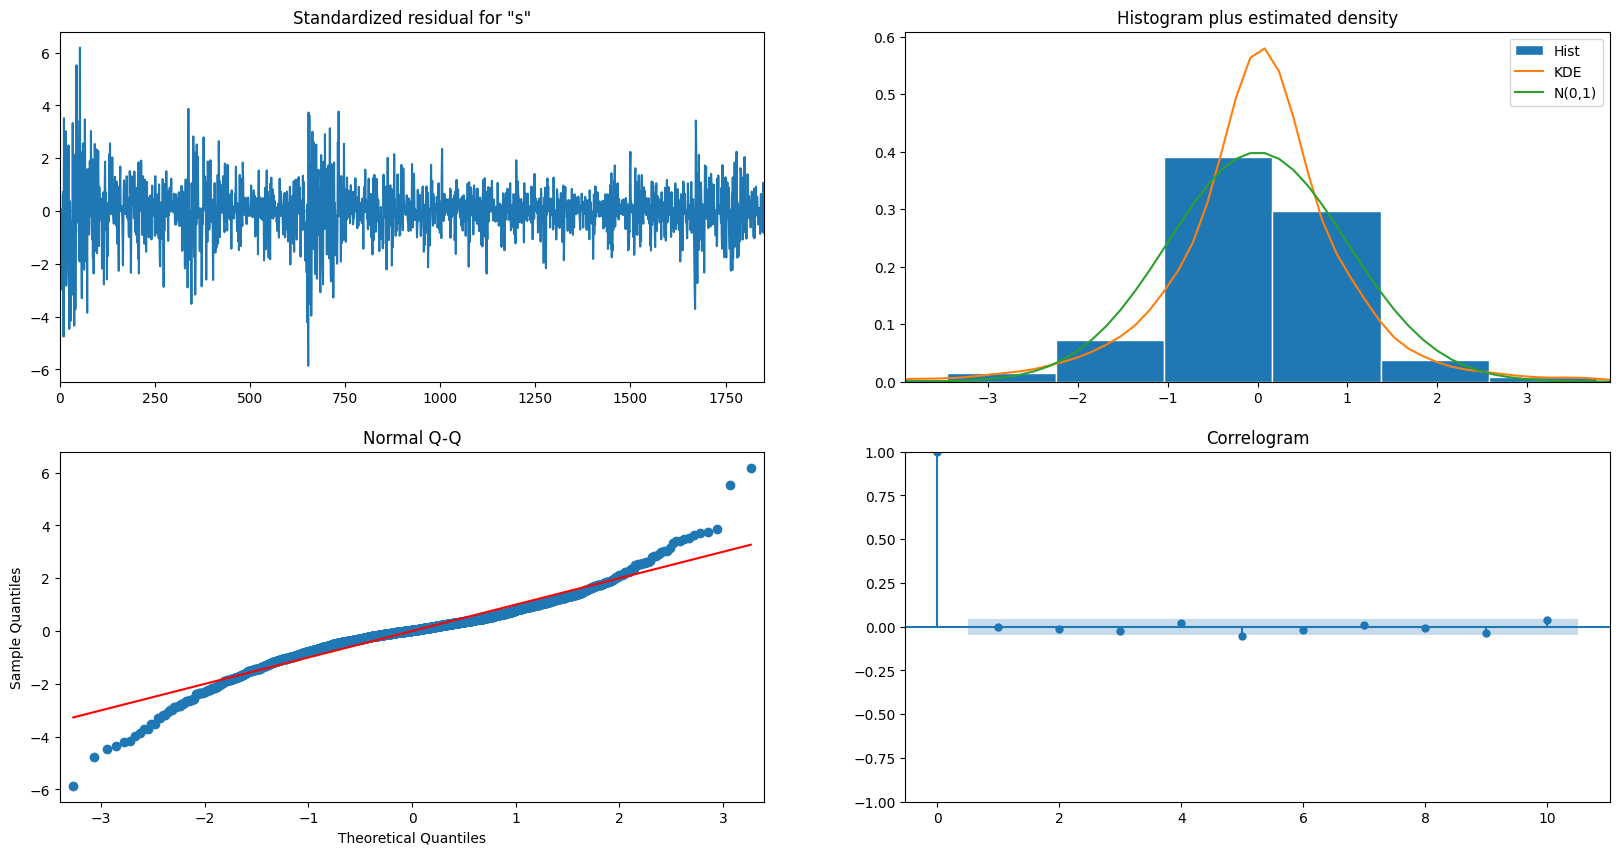

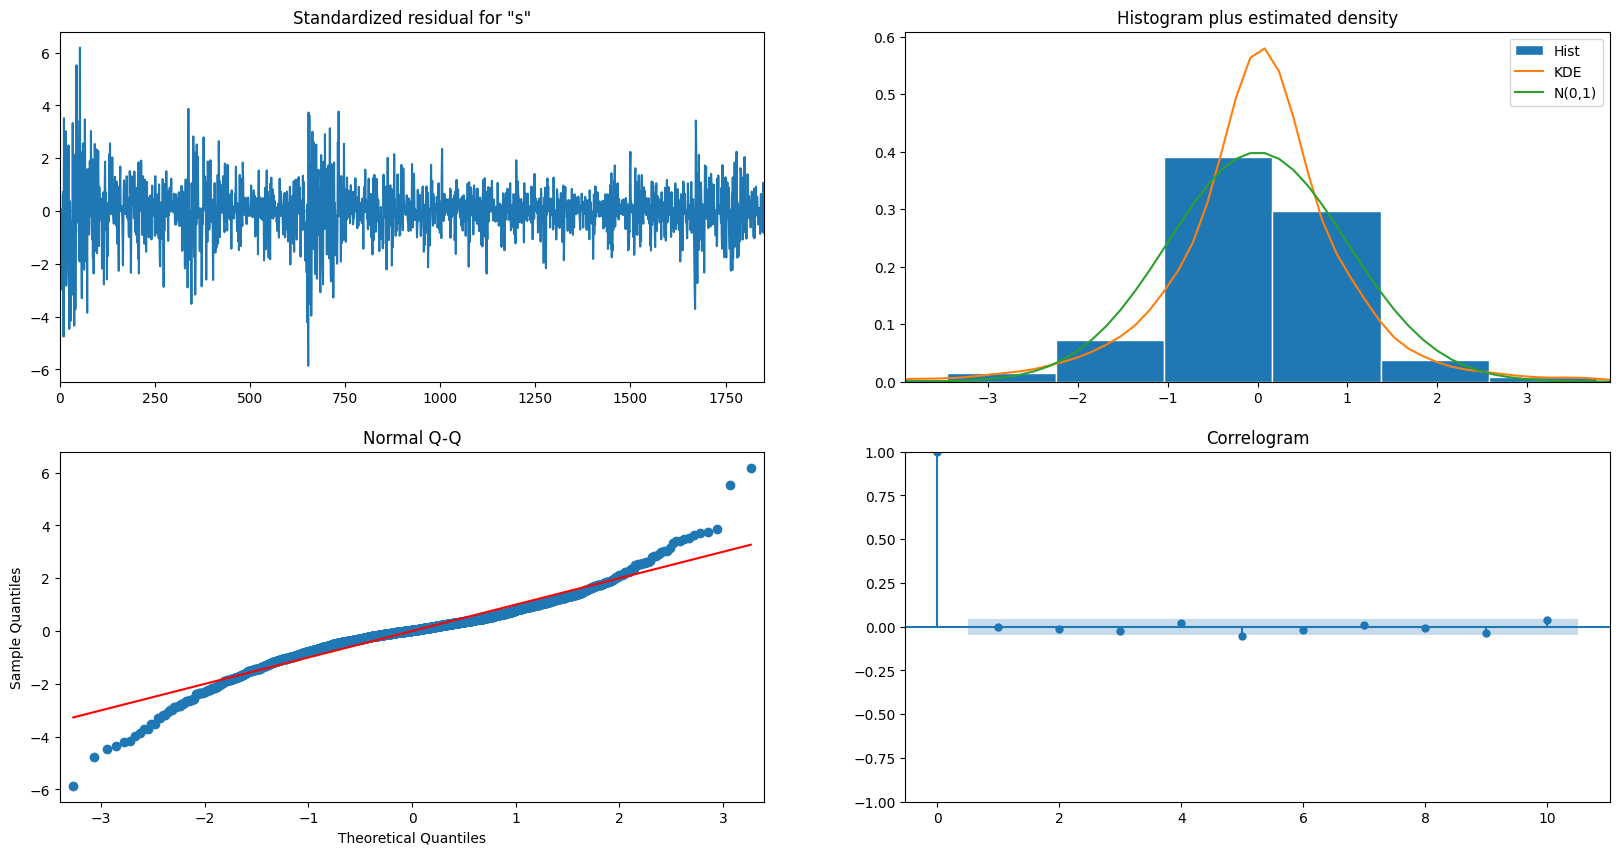

In [36]:
model_aic.plot_diagnostics(figsize=(20, 10))


**Evaluate the model**

In [37]:
training_window= 30
HORIZON = 5
order_best = (1,0,1)

train_ts=df_train['simple_return']
test_ts= df_test.copy()

history=[x for x in train_ts]
history=history[(-training_window):]

predictions=list()
# the number of forecast that not pass the white-noise test
count = 0
all_output=list()
# list of sum of each forecast
sums=list()

for i in range(test_ts.shape[0]):
    model = ARIMA(history, order=order_best)
    model_fit = model.fit()
    output = model_fit.forecast(steps=HORIZON)
    predictions.append(output[0])
    all_output.append(output)
    sums.append(sum(output))

    obs=list(test_ts.iloc[i])
    history.append(obs[0])
    history.pop(0)
    
    white_result = acorr_ljungbox(history, lags=None, boxpierce=False, 
               model_df=0, period=None, 
               return_df=True, auto_lag=False)
    
    if white_result.iloc[0, 1] < 0.01:
      print('test failed, the white result is ', white_result.iloc[0, 1])
      count = count + 1
    
    if i % 100 == 0:
      print(test_ts.index[i])
      print(i+1, ': predicted =', output, 'expected =', obs, 'white result =', white_result.iloc[0, 1])

2016/5/16
1 : predicted = [ 1.73431293e-03 -1.40424257e-03  4.28367892e-04 -6.41697974e-04
 -1.68838192e-05] expected = [0.009796688181920324] white result = 0.09085865551754738


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels

test failed, the white result is  0.007183123286046091
test failed, the white result is  0.00730240501027893
2016/10/6
101 : predicted = [-0.00148906 -0.00034238 -0.00035042 -0.00035037 -0.00035037] expected = [0.0004815416741907385] white result = 0.03531072585331905


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2017/3/2
201 : predicted = [0.00091803 0.00209595 0.00172404 0.00184147 0.00180439] expected = [-0.005859864104576021] white result = 0.20743875392384117


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

test failed, the white result is  0.009698889823841362
test failed, the white result is  0.009206575570610264
test failed, the white result is  0.007744253848760134
test failed, the white result is  0.009463694676768214
test failed, the white result is  0.009631500760312906
test failed, the white result is  0.009554392811805958
2017/7/25
301 : predicted = [0.00151535 0.00036902 0.00059883 0.00055276 0.00056199] expected = [0.0029231834358337976] white result = 0.010612539349236878
test failed, the white result is  0.009096423159956698


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


test failed, the white result is  0.009133431922641114


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


test failed, the white result is  0.009539250159430355
test failed, the white result is  0.009394184470760542
test failed, the white result is  0.009971777076035254
test failed, the white result is  0.009696033252824367


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels

2017/12/14
401 : predicted = [0.00142651 0.00089838 0.00127773 0.00100525 0.00120097] expected = [-0.004070826370242293] white result = 0.3375120914291636


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: Conver

2018/5/10
501 : predicted = [-1.61633808e-03 -6.12161733e-04 -2.10812048e-05  3.26841937e-04
  5.31637234e-04] expected = [0.009370632999603454] white result = 0.28542577290611126


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: Use

2018/10/2
601 : predicted = [0.000862 0.000862 0.000862 0.000862 0.000862] expected = [-0.00039663679353355827] white result = 0.8851781343922605


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st

2019/2/27
701 : predicted = [0.00461388 0.00333769 0.00285688 0.00267574 0.00260749] expected = [-0.0005440423780378617] white result = 0.5582995258603523


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Like

2019/7/22
801 : predicted = [-0.00035759  0.0008519   0.00129666  0.00146021  0.00152035] expected = [0.0028287212634507284] white result = 0.3417768792437148


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels

2019/12/11
901 : predicted = [0.00083445 0.00099148 0.00099826 0.00099855 0.00099856] expected = [0.0029082017034209287] white result = 0.6364448578607439


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels

In [38]:
all_output

[array([ 1.73431293e-03, -1.40424257e-03,  4.28367892e-04, -6.41697974e-04,
        -1.68838192e-05]),
 array([-0.00346383,  0.00170573, -0.00076546,  0.00041584, -0.00014885]),
 array([ 0.00329749, -0.00198368,  0.00132223, -0.00074721,  0.00054822]),
 array([-0.00299009,  0.00239465, -0.00298173,  0.00238631, -0.0029734 ]),
 array([ 7.45541504e-04, -3.25265998e-04,  1.12841832e-04, -6.64046436e-05,
         6.93186575e-06]),
 array([-1.43155143e-03,  9.13592759e-04, -3.82626027e-04,  3.33825929e-04,
        -6.21746623e-05]),
 array([ 7.22515726e-04, -1.34267474e-04,  1.66924834e-04,  6.10441323e-05,
         9.82652785e-05]),
 array([-0.00481308,  0.00497002, -0.00450883,  0.00467524, -0.00422322]),
 array([ 0.00111711, -0.00061249,  0.00075905, -0.00032856,  0.00053389]),
 array([-0.00204774,  0.0021658 , -0.00182842,  0.00195789, -0.00163133]),
 array([0.00013393, 0.00041327, 0.00017154, 0.00038073, 0.0001997 ]),
 array([-0.00023501,  0.00032011, -0.00018217,  0.0002723 , -0.00013

In [39]:
df_test['prediction']=predictions

In [40]:
sums

[9.985645796370423e-05,
 -0.002256569802834665,
 0.002437052095659829,
 -0.004164268477978574,
 0.00047364456012093776,
 -0.0006289334316639516,
 0.0009144824965663005,
 -0.0038998699410381357,
 0.001469008817999586,
 -0.0013837970872533566,
 0.0012991630334140737,
 3.63371588426365e-05,
 -0.0005719808330328416,
 0.000246093601622453,
 0.0013914341978122917,
 0.0003247180409581214,
 0.0025578457713739886,
 0.0011249744933661643,
 0.00288208280033105,
 0.0021723522649159163,
 0.002204435291159168,
 -0.0008150769551953933,
 0.001114673428873465,
 0.0015011956937094734,
 0.0028837056526413527,
 0.0005819031425107902,
 0.003363816060084366,
 -0.00035905866917884633,
 0.0022668515828445416,
 0.015946999443767824,
 -0.005171766489682807,
 -0.0023473106843796285,
 0.005381078363104226,
 0.003481500795571586,
 0.0066974439466268715,
 -0.0005374167274980969,
 0.009024935638656983,
 -0.0013128595343625204,
 0.007656678875366979,
 0.0013451598157485324,
 0.006897520000027136,
 0.00287257416204426

In [41]:
test_array = np.array(test_ts['simple_return'])
test_array

array([ 9.79668818e-03, -9.41132068e-03,  2.05157263e-04, -3.70672436e-03,
        6.01948981e-03, -2.08544476e-03,  1.36813734e-02,  6.97475025e-03,
       -2.10471935e-04,  4.28687623e-03, -1.00521186e-03,  1.13498176e-03,
        2.82471074e-03, -2.91175437e-03,  4.89726696e-03,  1.28946009e-03,
        3.30945538e-03, -1.71769414e-03, -9.17522264e-03, -8.11518699e-03,
       -1.79888988e-03, -1.84067999e-03,  3.13299541e-03, -3.25795601e-03,
        5.80817103e-03,  2.71210848e-03, -1.65158696e-03,  1.33640222e-02,
       -3.59197850e-02, -1.80965049e-02,  1.77702020e-02,  1.70326459e-02,
        1.35650024e-02,  1.94867690e-03, -6.84752372e-03,  5.35299610e-03,
       -8.71540627e-04,  1.52533486e-02,  3.40861073e-03,  7.00930206e-03,
        1.34749598e-04,  5.25917219e-03, -9.28942808e-04,  2.38234015e-03,
       -1.43523668e-03,  4.27030474e-03, -3.61248401e-03,  4.55391494e-03,
       -3.01145272e-03,  3.22806759e-04, -1.19860961e-03,  1.60621809e-03,
        1.63129130e-03, -

In [42]:
t_stat, p_value = stats.ttest_1samp(predictions, 0)

# 输出结果
print('t统计量:', t_stat)
print('p值:', p_value)

# 根据p值判断是否显著
alpha = 0.05 # 显著性水平
if p_value < alpha:
    print('收益率显著不等于0')
else:
    print('收益率不显著不等于0')

t统计量: 4.923028071939802
p值: 1.0112017851976975e-06
收益率显著不等于0


In [43]:
# evaluate forecasts
# example actual and predicted values
# define function to calculate SLE
def squared_log_error(y_true, y_pred):
    log_diff = np.log(np.array(y_true) + 1) - np.log(np.array(y_pred) + 1)
    return np.mean(log_diff**2)
sle = math.sqrt(squared_log_error(test_array, predictions))
print('Test RMSLE: %.10f' % sle)

Test RMSLE: 0.0086200649


In [44]:
# evaluate forecasts

def RMSE(y_true, y_pred):
  diff=np.array(y_true)-np.array(y_pred)
  return np.mean(diff**2)
rmse=math.sqrt(RMSE(test_array, predictions))
print('Test RMSE: %.10f' % rmse)


Test RMSE: 0.0086090625


In [45]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test_array, predictions)

print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.005724600791420966


In [46]:
correct_sign=0
for i in range(len(predictions)):
  if test_array[i]>0 and predictions[i]>0:
    correct_sign=correct_sign+1
  elif test_array[i]<0 and predictions[i]<0:
    correct_sign=correct_sign+1
  else:
    correct_sign=correct_sign

correct_sign

correct_percent=correct_sign/len(predictions)

print("number",correct_sign, "%",correct_percent)

number 471 % 0.515881708652793


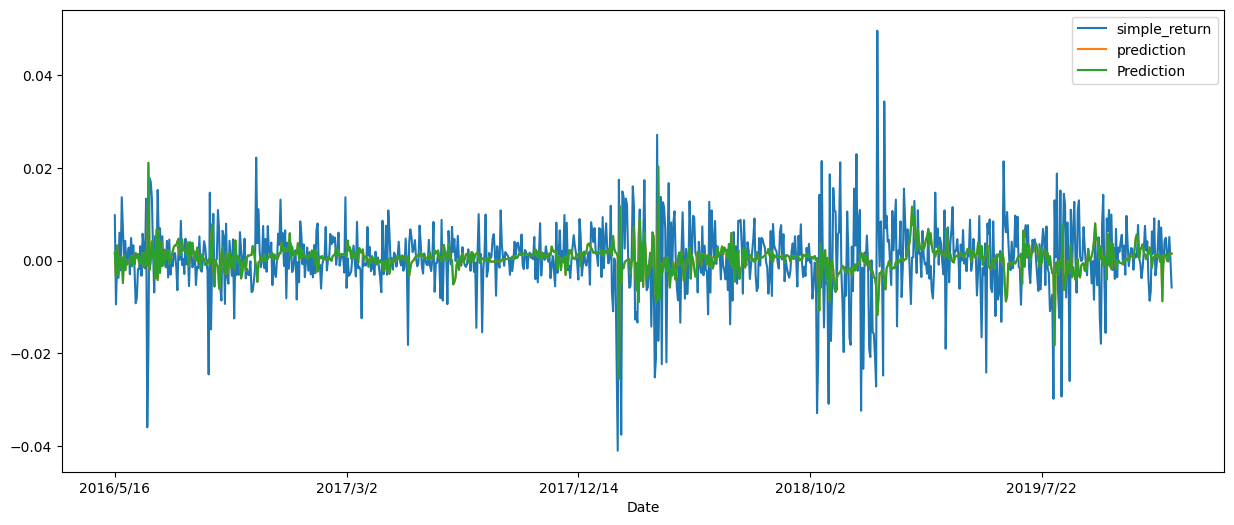

In [47]:
df_predict = pd.DataFrame(predictions)
df_predict.columns = ['Prediction']
ax = df_test.plot(figsize=(15, 6))
df_predict.plot(ax=ax)
ax.legend()

In [48]:
'''
residual = test_ts['simple_return'] - predict
residual
'''

"\nresidual = test_ts['simple_return'] - predict\nresidual\n"

In [49]:
''''
prediction_series = pd.Series(predict,index=test_ts.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(data.Value)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)
'''

"'\nprediction_series = pd.Series(predict,index=test_ts.index)\nfig, ax = plt.subplots(1, 1, figsize=(15, 5))\nax.plot(data.Value)\nax.plot(prediction_series)\nax.fill_between(prediction_series.index,\n                cf[0],\n                cf[1],color='grey',alpha=.3)\n"

# trading rules

In [50]:
# 转化为price
yesterday_price=[2046.61]

#每一步的变化因子
price_factors = np.array(predictions) + 1

#累乘
price_change_factors = np.cumprod(price_factors)

#计算每一步的price
pre_prices = yesterday_price * price_change_factors

# 将这些价格组成一个新的DataFrame
df_prices_from_predict = pd.DataFrame(pre_prices, columns=['price'])

df_prices_from_predict

,price
0,2050.159462
1,2043.058059
2,2049.795023
3,2043.665944
4,2045.189582
...,...
908,3081.273167
909,3082.469478
910,3086.932882
911,3091.771461


In [51]:
# 所有价格
prices = df[['Adj Close']]
# 训练集价格
train_prices = prices[:1853]
# 做一份df_test的拷贝
df_test_copy = df_test.copy()
# 在前面将predictions转化为prices，并记这个list为pre_prices
# 将prediction替换df_test的拷贝
df_test_copy['Adj Close'] = pre_prices
# 将prices那一列提取出来
df_pre_prices = df_test_copy[['Adj Close']]
# 合并两个dataframe为df_all_price
df_all_price = train_prices.append(df_pre_prices)
# df_trade为所有日期的MA
df_trade_all = df_all_price.rolling(100).mean()
df_trade_all.columns = ['MA_50']
# 截取测试集的MA
df_trade = df_trade_all[1853:]

df_trade

<ipython-input-51-77673629a1ea>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_price = train_prices.append(df_pre_prices)


,MA_50
Date,
2016/5/16,1996.894795
2016/5/17,1996.935675
2016/5/18,1996.790725
2016/5/19,1996.617485
2016/5/20,1996.504381
...,...
2019/12/23,2967.415039
2019/12/24,2967.966104
2019/12/26,2968.650252


In [52]:
long_position = 0 #看涨持仓
short_position = 0 #看跌持仓
cum_return=0 #单次交易的cum return
total_return=0
total_return_consider_cost=0
long_cost=0.0009
short_cost=0.0089
df_trade['return']=np.nan
return_list=[]
return_list_consider_cost=[]
df_trade['return_consider_cost']=np.nan
df_trade['signal']=np.nan
daily_hold_return=[0]
open_position_price=[]
sharp_r=[]
cun_daily_hold_return=0
# df_price是从5.13开始的
#sums是预测未来五天的sum of simple return

for i in range(len(predictions)):

  if sums[i]>0 and df_prices_from_predict['price'].iloc[i]>df_trade['MA_50'].iloc[i] and long_position==0 and short_position==0:
    long_position=1
    df_trade['signal'].iloc[i]=1 #buy long
    daily_profit=df_price['Adj Close'].iloc[i+1]-df_price['Adj Close'].iloc[i]
    cum_return=cum_return+daily_profit
    cum_daily_hold_return=daily_hold_return[i]+daily_profit
    daily_hold_return.append(cum_daily_hold_return)
    open_position_price.append(df_price['Adj Close'].iloc[i])
    cum_return_ratio=cum_return/open_position_price[i]
    sharp_r.append(df_test['simple_return'].iloc[i])



  elif ((sums[i]>0 and df_prices_from_predict['price'].iloc[i]>df_trade['MA_50'].iloc[i]) or \
	       (sums[i]>0 and df_prices_from_predict['price'].iloc[i]<df_trade['MA_50'].iloc[i]) \
				    or (sums[i]<0 and df_prices_from_predict['price'].iloc[i]>df_trade['MA_50'].iloc[i])) and \
						(cum_return_ratio<0.1 and cum_return_ratio>-0.05) and long_position==1 and short_position==0:
    df_trade['signal'].iloc[i]=2 #hold long
    daily_profit=df_price['Adj Close'].iloc[i+1]-df_price['Adj Close'].iloc[i]
    cum_return=cum_return+daily_profit
    cum_daily_hold_return=daily_hold_return[i]+daily_profit
    daily_hold_return.append(cum_daily_hold_return)
    open_position_price.append(open_position_price[i-1])
    cum_return_ratio=cum_return/open_position_price[i]
    sharp_r.append(df_test['simple_return'].iloc[i])    


  elif (cum_return_ratio>=0.1 or cum_return_ratio<=-0.05) and long_position==1 and short_position==0:
    #consider without transaction cost
    total_return=total_return+cum_return_ratio #将已获得的收益计算至我们总的收益中
    df_trade['return'].iloc[i]=cum_return_ratio #加入dataframe
    return_list.append(cum_return_ratio) #将此次交易的累计收益放进list中
    #consider with transcation cost
    total_return_consider_cost=total_return_consider_cost+cum_return_ratio-long_cost
    cum_return_consider_cost=cum_return_ratio-long_cost		
    df_trade['return_consider_cost'].iloc[i]=cum_return_consider_cost
    return_list_consider_cost.append(cum_return_consider_cost)
    #########
    cum_daily_hold_return=daily_hold_return[i]
    daily_hold_return.append(cum_daily_hold_return)
    open_position_price.append(1)      
    cum_return=0 #因为cum_return往后需要重新计算了
    cum_return_consider_cost=0
    df_trade['signal'].iloc[i]=3 #sell long
    long_position=0
    cum_return_ratio=0
    sharp_r.append(0)



  elif sums[i]<0 and df_prices_from_predict['price'].iloc[i]<df_trade['MA_50'].iloc[i] and long_position==1 and short_position==0:
    #consider without transaction cost
    total_return=total_return+cum_return_ratio #将已获得的收益计算至我们总的收益中
    df_trade['return'].iloc[i]=cum_return_ratio #加入dataframe
    return_list.append(cum_return_ratio) #将此次交易的累计收益放进list中
    #consider with transcation cost
    total_return_consider_cost=total_return_consider_cost+cum_return_ratio-long_cost
    cum_return_consider_cost=cum_return_ratio-long_cost		
    df_trade['return_consider_cost'].iloc[i]=cum_return_consider_cost
    return_list_consider_cost.append(cum_return_consider_cost)
    cum_return=0 #因为cum_return往后需要重新计算了
    cum_return_consider_cost=0
    df_trade['signal'].iloc[i]=4 #sell long & buy short
    long_position=0
    short_position=1
    cum_return=cum_return-df_test['simple_return'].iloc[i]
    #######
    daily_profit=df_price['Adj Close'].iloc[i]-df_price['Adj Close'].iloc[i+1]
    cum_return=cum_return+daily_profit
    cum_daily_hold_return=daily_hold_return[i]+daily_profit
    daily_hold_return.append(cum_daily_hold_return)
    open_position_price.append(df_price['Adj Close'].iloc[i])
    cum_return_ratio=cum_return/open_position_price[i]
    sharp_r.append(df_test['simple_return'].iloc[i]*(-1))


  elif sums[i]<0 and df_prices_from_predict['price'].iloc[i]<df_trade['MA_50'].iloc[i] and long_position==0 and short_position==0:
    short_position = 1
    df_trade['signal'].iloc[i]=5 #buy short
    daily_profit=df_price['Adj Close'].iloc[i]-df_price['Adj Close'].iloc[i+1]
    cum_return=cum_return+daily_profit
    cum_daily_hold_return=daily_hold_return[i]+daily_profit
    daily_hold_return.append(cum_daily_hold_return)
    open_position_price.append(df_price['Adj Close'].iloc[i])
    cum_return_ratio=cum_return/open_position_price[i]   
    sharp_r.append(df_test['simple_return'].iloc[i]*(-1))


  elif ((sums[i]<0 and df_prices_from_predict['price'].iloc[i]<df_trade['MA_50'].iloc[i]) or\
	       (sums[i]>0 and df_prices_from_predict['price'].iloc[i]<df_trade['MA_50'].iloc[i]) \
				    or (sums[i]<0 and df_prices_from_predict['price'].iloc[i]>df_trade['MA_50'].iloc[i])) and \
						(cum_return_ratio<0.1 and cum_return_ratio>-0.05) and long_position==0 and short_position==1:
    df_trade['signal'].iloc[i]=6 #hold short
    daily_profit=df_price['Adj Close'].iloc[i]-df_price['Adj Close'].iloc[i+1]
    cum_return=cum_return+daily_profit
    cum_daily_hold_return=daily_hold_return[i]+daily_profit
    daily_hold_return.append(cum_daily_hold_return)
    open_position_price.append(df_price['Adj Close'].iloc[i])
    cum_return_ratio=cum_return/open_position_price[i]   
    sharp_r.append(df_test['simple_return'].iloc[i]*(-1))

  elif (cum_return_ratio>=0.1 or cum_return_ratio<=--0.05) and long_position==0 and short_position==1:
    #consider without transaction cost
    total_return=total_return+cum_return_ratio #将已获得的收益计算至我们总的收益中
    df_trade['return'].iloc[i]=cum_return_ratio #加入dataframe
    return_list.append(cum_return_ratio) #将此次交易的累计收益放进list中
    #consider with transcation cost
    total_return_consider_cost=total_return_consider_cost+cum_return_ratio-short_cost
    cum_return_consider_cost=cum_return_ratio-short_cost		
    df_trade['return_consider_cost'].iloc[i]=cum_return_consider_cost
    return_list_consider_cost.append(cum_return_consider_cost)
    #########
    cum_daily_hold_return=daily_hold_return[i]
    daily_hold_return.append(cum_daily_hold_return)
    open_position_price.append(1)    
    cum_return=0 #因为cum_return往后需要重新计算了
    cum_return_consider_cost=0
    df_trade['signal'].iloc[i]=7 #sell short
    short_position=0
    cum_return_ratio=0 
    sharp_r.append(0)


  elif sums[i]>0 and df_prices_from_predict['price'].iloc[i]>df_trade['MA_50'].iloc[i] and long_position==0 and short_position==1:
    #consider without transaction cost
    total_return=total_return+cum_return_ratio #将已获得的收益计算至我们总的收益中
    df_trade['return'].iloc[i]=cum_return_ratio #加入dataframe
    return_list.append(cum_return_ratio) #将此次交易的累计收益放进list中
    #consider with transcation cost
    total_return_consider_cost=total_return_consider_cost+cum_return_ratio-short_cost
    cum_return_consider_cost=cum_return_ratio-short_cost		
    df_trade['return_consider_cost'].iloc[i]=cum_return_consider_cost
    return_list_consider_cost.append(cum_return_consider_cost)
    cum_return=0 #因为cum_return往后需要重新计算了
    cum_return_consider_cost=0
    df_trade['signal'].iloc[i]=8 #sell short & buy long
    long_position=1
    short_position=0
    cum_return=cum_return+df_test['simple_return'].iloc[i]
    daily_profit=df_price['Adj Close'].iloc[i+1]-df_price['Adj Close'].iloc[i]
    cum_return=cum_return+daily_profit
    cum_daily_hold_return=daily_hold_return[i]+daily_profit
    daily_hold_return.append(cum_daily_hold_return)
    open_position_price.append(df_price['Adj Close'].iloc[i])
    cum_return_ratio=cum_return/open_position_price[i]
    sharp_r.append(df_test['simple_return'].iloc[i])


  else:
    df_trade['signal'].iloc[i]=9 # no position
    cum_daily_hold_return=daily_hold_return[i]
    daily_hold_return.append(cum_daily_hold_return)
    open_position_price.append(1)
    cum_return_ratio=0
    sharp_r.append(0)


<ipython-input-52-8f5971d4d594>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trade['return']=np.nan
<ipython-input-52-8f5971d4d594>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trade['return_consider_cost']=np.nan
<ipython-input-52-8f5971d4d594>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [53]:
'''
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
'''
df_trade

,MA_50,return,return_consider_cost,signal
Date,,,,
2016/5/16,1996.894795,NaN,NaN,1.0
2016/5/17,1996.935675,NaN,NaN,2.0
2016/5/18,1996.790725,NaN,NaN,2.0
2016/5/19,1996.617485,NaN,NaN,2.0
2016/5/20,1996.504381,NaN,NaN,2.0
...,...,...,...,...
2019/12/23,2967.415039,NaN,NaN,2.0
2019/12/24,2967.966104,NaN,NaN,2.0
2019/12/26,2968.650252,NaN,NaN,2.0


In [54]:
total_return

0.3059695356208527

In [55]:
total_return_consider_cost

0.24536953562085267

In [56]:
from scipy.stats import ttest_1samp
import numpy as np


# Perform the one-sample t-test
t_statistic, p_value = ttest_1samp(return_list_consider_cost, 0)

# Print the results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: 0.9041469725924759
p-value: 0.3823671376758211


In [57]:
df_trading_evaluate = pd.DataFrame()

df_trading_evaluate['return_list'] = return_list

df_trading_evaluate['return_list_consider_cost'] = return_list_consider_cost

df_trading_evaluate

,return_list,return_list_consider_cost
0,0.104035,0.103135
1,0.102417,0.101517
2,0.100634,0.099734
3,-0.061895,-0.062795
4,-0.015475,-0.016375
5,-0.033565,-0.042465
6,-0.017899,-0.018799
7,0.117113,0.108213
8,-0.055813,-0.064713
9,-0.057421,-0.066321


In [58]:
df_trading_evaluate.describe()

,return_list,return_list_consider_cost
count,14.000000,14.000000
mean,0.021855,0.017526
std,0.070765,0.072530
min,-0.061895,-0.066321
25%,-0.036447,-0.045347
50%,-0.004506,-0.009406
75%,0.101971,0.101071
max,0.117113,0.108213


In [59]:
daily_hold_return.remove(0)

In [60]:
df_copy_data=df_test.copy()

In [61]:
df_copy_data['net return']=daily_hold_return

In [62]:
df_copy_data

,simple_return,prediction,net return
Date,,,
2016/5/16,0.009797,0.001734,20.05
2016/5/17,-0.009411,-0.003464,0.60
2016/5/18,0.000205,0.003297,1.02
2016/5/19,-0.003707,-0.002990,-6.57
2016/5/20,0.006019,0.000746,5.71
...,...,...,...
2019/12/23,0.000866,-0.000044,687.87
2019/12/24,-0.000195,0.000388,687.24
2019/12/26,0.005128,0.001448,703.77


In [63]:
def maxdrawdown_1(arr):
	i = np.argmax((np.maximum.accumulate(arr) - arr)/np.maximum.accumulate(arr)) # end of the period
	j = np.argmax(arr[:i]) # start of period
	return (1-arr[i]/arr[j])
 
maxdrawdown_1(daily_hold_return)

1.6353606399117355

In [64]:
def MaxDrawdown(return_list):
    '''最大回撤率'''
    i = np.argmax((np.maximum.accumulate(return_list) - return_list) / np.maximum.accumulate(return_list))  # 结束位置
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])  # 开始位置
    return (return_list[j] - return_list[i]) / (return_list[j])
 
 
print(MaxDrawdown(daily_hold_return))


1.6353606399117355


In [65]:
df_sharpe_ratio = pd.DataFrame()
df_sharpe_ratio['return']=sharp_r
df_sharpe_ratio['excess_returns']=df_sharpe_ratio['return']-0.00002074
mean_excess_returns = df_sharpe_ratio['excess_returns'].mean()
std_excess_returns = df_sharpe_ratio['excess_returns'].std()

sharpe_ratio = mean_excess_returns / std_excess_returns

sharpe_ratio

0.03635845552106506

In [66]:
df_sharpe_ratio['return'].describe()

count    913.000000
mean       0.000303
std        0.007773
min       -0.049594
25%       -0.002578
50%        0.000267
75%        0.004007
max        0.032365
Name: return, dtype: float64

buy and hold strategy

In [67]:
buy_and_hold=0
for i in range(len(predictions)):
  buy_and_hold=buy_and_hold+df_test['simple_return'].iloc[i]

buy_and_hold

0.48206941805297254

In [68]:
buy_and_hold-long_cost

0.48116941805297253

In [69]:
bh_net_profit=[0]
for i in range(len(predictions)):
  bh_net_profit.append(bh_net_profit[i]+df_test['simple_return'].iloc[i])

bh_net_profit.remove(0)
MaxDrawdown(bh_net_profit)


1.6117801787298849

In [70]:
df_sharpe_ratio = pd.DataFrame()
df_sharpe_ratio['return']=df_test['simple_return']
df_sharpe_ratio['excess_returns']=df_sharpe_ratio['return']-0.00002074
mean_excess_returns = df_sharpe_ratio['excess_returns'].mean()
std_excess_returns = df_sharpe_ratio['excess_returns'].std()

sharpe_ratio = mean_excess_returns / std_excess_returns

sharpe_ratio

0.06442363248308275